# Optimizing App Offers With Starbucks
### Notebook 3: Predictions

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

import sklearn.model_selection

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Custom colors that we will use in graphs:
custom_colors = ['#006241', '#84233C', '#1E3932', '#9D5116', '#E44C2C']

In [3]:
csv_file = 'data/clean_df.csv'
clean_df = pd.read_csv(csv_file)

clean_df.head()

,possible_reward,spent_required,duration,offer_type,offer_id,short_offer_id,duration_hrs,channel_email,channel_mobile,channel_social,...,days_of_membership,event,hours_after_start,money_spent,money_gained,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,event_auto_completed
0,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,527,offer received,408,NaN,NaN,0,1,0,0,0
1,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,527,offer viewed,408,NaN,NaN,0,0,1,0,0
2,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,381,offer received,168,NaN,NaN,0,1,0,0,0
3,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,420,offer received,576,NaN,NaN,0,1,0,0,0
4,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,420,offer completed,684,54.61,10.0,1,0,1,1,0


In [4]:
list(clean_df.columns) 

['possible_reward',
 'spent_required',
 'duration',
 'offer_type',
 'offer_id',
 'short_offer_id',
 'duration_hrs',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'gender',
 'age',
 'person',
 'became_member_on',
 'income',
 'days_of_membership',
 'event',
 'hours_after_start',
 'money_spent',
 'money_gained',
 'event_offer_completed',
 'event_offer_received',
 'event_offer_viewed',
 'event_transaction',
 'event_auto_completed']

#### Drop the "unknown" customer data

See Data Exploration notebook for more info about "unknown" customers.

In [5]:
clean_df = clean_df[clean_df.age != -1]
clean_df.age.describe()

count    209030.000000
mean         53.318323
std          17.724360
min          18.000000
25%          40.000000
50%          54.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

#### Drop the columns that will not be used for modeling

In [6]:
columns_to_keep = ['person',
 'gender',
 'age',
 'income',
 'offer_type',
 'event_offer_received',
 'event_offer_viewed',
 'event_offer_completed']

clean_df = clean_df[columns_to_keep]
clean_df.sample(3)

,person,gender,age,income,offer_type,event_offer_received,event_offer_viewed,event_offer_completed
173100,03b326a99f5345df8b4d21ed26bdb0da,F,80,85000.0,NaN,0,0,0
195076,190fcd45fd074de8b41531fc6ffa6f42,M,26,33000.0,NaN,0,0,0
6029,a89e75b62ad648d68d4160653f36d901,M,44,65000.0,bogo,1,0,0


#### Prepare data labels - "no view", "no order", "possible order"

In [7]:
df = clean_df.groupby(['person', 'gender', 'age', 'income', 'offer_type'], as_index=False).sum()
df.sample(3)

,person,gender,age,income,offer_type,event_offer_received,event_offer_viewed,event_offer_completed
15088,6da8765ed47745959fd67865d3799206,F,82,84000.0,informational,1,1,1
15134,6e084f6ef50c46f0af01e02060a7c1a0,M,39,56000.0,discount,2,2,1
33271,f10d90acb03b43e094f755e607388657,F,63,113000.0,discount,3,2,1


In [8]:
# First, compare how many times the offer was viewed vs. received:
df['label'] = np.where((df['event_offer_viewed'] >= df['event_offer_received']) &
                       (df['event_offer_viewed'] > 0), "no order", "no view")

# Next, compare how many times offer was completed vs. viewed
# We use 0.5 threshold as in at least half of offers has to be completed:
df['label'] = np.where(((df['event_offer_completed'] / df['event_offer_viewed']) >= 0.5) &
                       (df['event_offer_viewed'] > 0) & 
                       (df['event_offer_completed'] > 0), "possible order", "no order")

# Finally, if there is no order and no view:
df['label'] = np.where((df['event_offer_viewed'] == 0) & 
                       (df['event_offer_completed'] == 0), "no view", df['label'])

df.sample(10)

,person,gender,age,income,offer_type,event_offer_received,event_offer_viewed,event_offer_completed,label
15224,6ea759e2e1234242a48a575597924934,F,52,84000.0,discount,2,1,1,possible order
33807,f5112242df984403bfb4176d4487aef3,F,96,72000.0,discount,3,3,2,possible order
30111,da50429e4d43437eb8073e4264e686a5,M,61,82000.0,bogo,1,1,1,possible order
1209,093f0c09cc7242228edbb0e52ca14af6,M,36,35000.0,discount,3,3,3,possible order
26342,bd777dba9c784ff8aa96c2a4531fba1f,M,84,93000.0,bogo,3,2,2,possible order
25459,b702b01e1767462aa447431c9e8a07f9,M,57,110000.0,bogo,1,1,1,possible order
5533,2a070c1a63e348fda6f9772df48f4c85,M,73,36000.0,discount,1,1,0,no order
23698,aa83af3a55f543d190400dc9392cb80f,M,76,54000.0,discount,2,2,0,no order
23873,aba68a20aa8a42acbe25ebcf0800414b,M,24,51000.0,discount,1,1,0,no order
11824,558cb2d5299f4ddd99d684ccc3c8b189,M,63,55000.0,discount,1,1,0,no order


In [9]:
# Drop the event columns, we don't need them anymore:
df = df.drop(['event_offer_received', 'event_offer_viewed', 'event_offer_completed'], axis=1)

#### Convert labels to numeric

In [10]:
df["output"] = np.where(df['label']=='no view', 0, np.nan)
df["output"] = np.where(df['label']=='no order', 1, df["output"])
df["output"] = np.where(df['label']=='possible order', 2, df["output"])

df.groupby(['label', 'output']).mean().index

MultiIndex(levels=[['no order', 'no view', 'possible order'], [0.0, 1.0, 2.0]],
           codes=[[0, 1, 2], [1, 0, 2]],
           names=['label', 'output'])

#### Check for missing values

In [11]:
df.isnull().sum()

person        0
gender        0
age           0
income        0
offer_type    0
label         0
output        0
dtype: int64

#### Encode "gender" and "offer_type" using a one-hot encoding scheme

In [12]:
df = df.join(pd.get_dummies(df['gender'])).drop('gender', axis=1) # drop the original column

for column in ['M', 'F', 'O', 'U']:
    df = df.rename(columns={column: ("gender_" + column.replace(" ", "_"))}) # rename new columns
    
    
df = df.join(pd.get_dummies(df['offer_type'])).drop('offer_type', axis=1) # drop the original column

#### Drop the "person" and "label" columns

In [13]:
df = df.drop(['person', 'label'], axis=1)

df.sample(3)

,age,income,output,gender_F,gender_M,gender_O,bogo,discount,informational
25690,44,68000.0,2.0,0,1,0,0,1,0
1079,58,55000.0,1.0,0,1,0,0,1,0
3955,48,71000.0,0.0,1,0,0,0,1,0


In [14]:
df.shape

(35324, 9)

#### Split the data to input features (X) and output labels (y)

In [15]:
X_df = df.drop(['output'], axis=1)
y_df = df['output']

print("X:")
print(X_df.head())

print("\n\n\ny:")
print(y_df.head())

X:
   age   income  gender_F  gender_M  gender_O  bogo  discount  informational
0   33  72000.0         0         1         0     1         0              0
1   33  72000.0         0         1         0     0         1              0
2   33  72000.0         0         1         0     0         0              1
3   40  57000.0         0         0         1     1         0              0
4   40  57000.0         0         0         1     0         1              0



y:
0    1.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: output, dtype: float64


#### Split the rows up into train, test and validation sets

In [16]:
# Split the dataset into 2/3 training and 1/3 testing sets:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_df, y_df, test_size=0.33)

# Next, split the TRAINING set further into 2/3 training and 1/3 validation sets:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.33)

print("X training set:")
print(X_train.shape)

print("\nX valitation set:")
print(X_val.shape)   
                                                                          
print("\nX test set:")
print(X_test.shape)

X training set:
(15856, 8)

X valitation set:
(7811, 8)

X test set:
(11657, 8)


#### Save the data locally as CSV files

Amazon SageMaker requires that a CSV file **doesn't have a header** record and that the **target variable is in the first column** (from https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).

In [17]:
data_dir = '../data' 
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Save testing set:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# Save training and validation sets:
pd.concat([y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

#### Upload the data files to S3

In [18]:
prefix = 'starbucks-xgboost'

session = sagemaker.Session()

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Training the XGBoost model

#### Construct the estimator object

In [19]:
role = get_execution_role()

# Get the URI for new container:
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# Construct the estimator object:
xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session) 

#### Set model specific hyperparameter default values

We will use "**multi:softprob**" objective, which outputs a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class (from https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst).

In [20]:
xgb.set_hyperparameters(num_round=500, # the number of rounds to run the training
                        num_class=3, # the number of output classes
                        objective='multi:softprob')

#### Train model on default parameters

In [21]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-02-01 16:54:47 Starting - Starting the training job...
2020-02-01 16:54:49 Starting - Launching requested ML instances......
2020-02-01 16:55:53 Starting - Preparing the instances for training......
2020-02-01 16:57:14 Downloading - Downloading input data
2020-02-01 16:57:14 Training - Downloading the training image...
2020-02-01 16:57:45 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softprob to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[16:57:48] 15856x8 matrix with 126848 entries loaded from /opt/ml/i

#### Test default model performance

In [22]:
# Build a transformer object from our fit model:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

# Begin a batch transform job using our trained model and applying it to the test data:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [23]:
xgb_transformer.wait()

......................[2020-02-01 17:02:07 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2020-02-01 17:02:07 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2020-02-01 17:02:07 +0000] [14] [INFO] Using worker: gevent
[2020-02-01 17:02:07 +0000] [21] [INFO] Booting worker with pid: 21
[2020-02-01 17:02:07 +0000] [25] [INFO] Booting worker with pid: 25
[2020-02-01 17:02:08 +0000] [26] [INFO] Booting worker with pid: 26
[2020-02-01 17:02:08 +0000] [27] [INFO] Booting worker with pid: 27

[2020-02-01:17:02:37:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [01/Feb/2020:17:02:37 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-02-01:17:02:37:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [01/Feb/2020:17:02:37 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-02-01:17:02:37:INFO] No GPUs detected (normal if no gpus installed)
[2020-02-01:17:02:37:INFO] Determined delimiter of CSV

In [24]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-037802178319/sagemaker-xgboost-2020-02-01-16-58-41-381/test.csv.out to ../data/test.csv.out


In [25]:
y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
y_pred.head()

,0,1,2
0,[0.07351533323526382,0.026411,0.9000735282897949]
1,[0.06258437782526016,0.595232,0.34218382835388184]
2,[0.04993101581931114,0.057054,0.8930152058601379]
3,[0.07440779358148575,0.323170,0.6024218797683716]
4,[0.03284726291894913,0.075518,0.8916345834732056]


In [26]:
# Fix the brackets and convert string to a float:
y_pred[0] = y_pred[0].str.strip('[').astype(float)
y_pred[2] = y_pred[2].str.strip(']').astype(float)

y_pred.head()

,0,1,2
0,0.073515,0.026411,0.900074
1,0.062584,0.595232,0.342184
2,0.049931,0.057054,0.893015
3,0.074408,0.323170,0.602422
4,0.032847,0.075518,0.891635


In [27]:
# Choose the most likely output based on predicted probabilities:
y_max = pd.DataFrame()
y_max[0] = y_pred[[0, 1, 2]].idxmax(axis=1)

y_max.head()

,0
0,2
1,1
2,2
3,2
4,2


In [28]:
from sklearn.metrics import accuracy_score

print("Default model accuracy score: {:.4f}".format(accuracy_score(y_test, y_max)))

Default model accuracy score: 0.5519


## Model refinement
#### Create the hyperparameter tuner

Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose (from https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html).

To compare the trained models, we will use **merror**: multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).

We will use following hyperparameters to refine the initial model:
(from https://xgboost.readthedocs.io/en/latest/parameter.html)

- **eta**: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

- **gamma**: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

- **max_depth**: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

- **subsample**: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration

In [29]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # the estimator object to use as the basis
                                               objective_metric_name = 'validation:merror', # the metric used to compare trained models
                                               objective_type = 'Minimize', # whether we wish to minimize or maximize the metric
                                               max_jobs = 32, # the total number of models to train
                                               max_parallel_jobs = 3, # the number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'gamma': ContinuousParameter(0, 10),
                                                    'max_depth': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 1),
                                               })

#### Find the best version of a model by running many training jobs

In [30]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [31]:
xgb_hyperparameter_tuner.wait()

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


#### Retrieve and set up the best performing model

In [32]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-200201-1703-001-0e60ab7e'

In [33]:
# Set up a batch transform job to test the best model:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-02-01 17:06:30 Starting - Preparing the instances for training
2020-02-01 17:06:30 Downloading - Downloading input data
2020-02-01 17:06:30 Training - Training image download completed. Training in progress.
2020-02-01 17:06:30 Uploading - Uploading generated training model
2020-02-01 17:06:30 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:merror to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softprob to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:06

#### Test new model performance

In [34]:
# Build a transformer object from our fit model:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

# Begin a batch transform job using our trained model and applying it to the test data:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [35]:
xgb_transformer.wait()

.......................[2020-02-01 17:51:20 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2020-02-01 17:51:20 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2020-02-01 17:51:20 +0000] [14] [INFO] Using worker: gevent
[2020-02-01 17:51:20 +0000] [21] [INFO] Booting worker with pid: 21
[2020-02-01 17:51:20 +0000] [22] [INFO] Booting worker with pid: 22
[2020-02-01 17:51:20 +0000] [23] [INFO] Booting worker with pid: 23
[2020-02-01 17:51:20 +0000] [30] [INFO] Booting worker with pid: 30

[2020-02-01:17:51:42:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [01/Feb/2020:17:51:42 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-02-01:17:51:42:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [01/Feb/2020:17:51:42 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-02-01:17:51:43:INFO] Determined delimiter of CSV input is ','
[2020-02-01:17:51:42:INFO] No GPUs detected (normal if no g

In [36]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-037802178319/sagemaker-xgboost-200201-1703-001-0e60a-2020-02-01-17-47-49-061/test.csv.out to ../data/test.csv.out


In [37]:
y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
y_pred[0] = y_pred[0].str.strip('[').astype(float)
y_pred[2] = y_pred[2].str.strip(']').astype(float)

y_max = pd.DataFrame()
y_max[0] = y_pred[[0, 1, 2]].idxmax(axis=1)

print("Tuned model accuracy score: {:.4f}".format(accuracy_score(y_test, y_max)))

Tuned model accuracy score: 0.6050


In [38]:
from sklearn.metrics import classification_report

labels = ["no view", "no order", "possible order"]
print(classification_report(y_test, y_max, target_names=labels))

                precision    recall  f1-score   support

       no view       0.00      0.00      0.00      1606
      no order       0.58      0.18      0.28      3224
possible order       0.61      0.95      0.74      6827

     micro avg       0.60      0.60      0.60     11657
     macro avg       0.39      0.38      0.34     11657
  weighted avg       0.52      0.60      0.51     11657



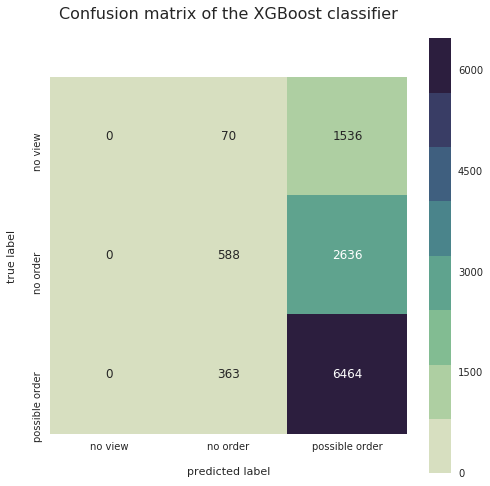

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_max)

f, ax = plt.subplots(figsize = (8,8))

sns.heatmap(cm,
            cmap=sns.cubehelix_palette(8, start=.5, rot=-.75),
            square=True,
            annot=True, annot_kws={"size": 12}, fmt='g',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion matrix of the XGBoost classifier\n\n\n', fontsize=16)

plt.xlabel("\npredicted label")
plt.ylabel("true label\n")

plt.show()

## Deploy the XGBoost model
#### Create a simulated data set with new customers
The purpose of this model is to be able to use existing data to target **new customers** with offers. When new customer registers in the Starbucks Rewards® program, we can feed it's data to the deployed model and draw a conclusions about possible offer types for this customer.

We don't have real data about new customers, so we will generate this data.

In [40]:
new_customers = pd.DataFrame()

new_customers.colums = ['age', 'income', 'gender', 'bogo', 'discount', 'informational']
new_customers['age'] = np.random.randint(18, 85, 10) # random ages from 18 to 85
new_customers['income'] = np.random.randint(20000, 120000, 10) # random income from 20000 to 120000

new_customers['gender'] = np.random.choice(['F','M','O'], 10) # random gender
# One-hot encode gender:
new_customers = new_customers.join(pd.get_dummies(new_customers['gender'])).drop('gender', axis=1) 
for column in ['M', 'F', 'O', 'U']:
    new_customers = new_customers.rename(columns={column: ("gender_" + column.replace(" ", "_"))})

new_customers['bogo'] = 0
new_customers['discount'] = 0
new_customers['informational'] = 0

new_customers['person'] = new_customers.index

new_customers

,age,income,gender_F,gender_M,gender_O,bogo,discount,informational,person
0,20,75724,0,0,1,0,0,0,0
1,24,118385,0,0,1,0,0,0,1
2,47,29441,1,0,0,0,0,0,2
3,59,33835,0,1,0,0,0,0,3
4,18,119267,1,0,0,0,0,0,4
5,37,85146,1,0,0,0,0,0,5
6,32,70816,0,0,1,0,0,0,6
7,66,47565,0,1,0,0,0,0,7
8,76,115821,0,1,0,0,0,0,8
9,24,54680,0,0,1,0,0,0,9


#### Assign all three offer types to each customer 

In [41]:
df1, df2, df3 = new_customers.copy(), new_customers.copy(), new_customers.copy()

df1['bogo'] = 1
df2['discount'] = 1
df3['informational'] = 1

frames = [df1, df2, df3]

new_customers = pd.concat(frames, ignore_index=True)

new_customers = new_customers.sort_values(by=['age', 'bogo', 'discount'])
new_customers.head(6)

,age,income,gender_F,gender_M,gender_O,bogo,discount,informational,person
24,18,119267,1,0,0,0,0,1,4
14,18,119267,1,0,0,0,1,0,4
4,18,119267,1,0,0,1,0,0,4
20,20,75724,0,0,1,0,0,1,0
10,20,75724,0,0,1,0,1,0,0
0,20,75724,0,0,1,1,0,0,0


#### Deploy final XGBoost model into production

In [42]:
xgb_predictor = xgb_attached.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------!

#### Generate predictions for new customers

In [43]:
X = new_customers.drop(['person'], axis=1)
X_id = new_customers['person']

# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

# Predictions is currently a comma delimited string:
y_pred_raw = xgb_predictor.predict(X.values).decode('utf-8')

# Convert predictions to a dataframe:
y_pred = pd.DataFrame(y_pred_raw.split("],["))
y_pred = y_pred[0].str.split(',', expand=True)

# Fix the brackets and convert string to a float:
y_pred[0] = y_pred[0].str.strip('[').astype(float)
y_pred[1] = y_pred[0].astype(float)
y_pred[2] = y_pred[2].str.strip(']').astype(float)

y_pred.head()

,0,1,2
0,0.258858,0.258858,0.536419
1,0.251850,0.251850,0.534075
2,0.109876,0.109876,0.615248
3,0.193794,0.193794,0.613711
4,0.155772,0.155772,0.598766


#### Shut down the endpoint

In [44]:
xgb_predictor.delete_endpoint()

### Explore prediction results

#### Combine new customer data with the predictions

In [45]:
df = pd.concat([new_customers, y_pred], axis=1, sort=False)
df.head()

,age,income,gender_F,gender_M,gender_O,bogo,discount,informational,person,0,1,2
0,20,75724,0,0,1,1,0,0,0,0.258858,0.258858,0.536419
1,24,118385,0,0,1,1,0,0,1,0.251850,0.251850,0.534075
2,47,29441,1,0,0,1,0,0,2,0.109876,0.109876,0.615248
3,59,33835,0,1,0,1,0,0,3,0.193794,0.193794,0.613711
4,18,119267,1,0,0,1,0,0,4,0.155772,0.155772,0.598766


In [46]:
df.shape

(30, 12)

In [47]:
y_pred.iloc[3] # just to check if the merge was correct

0    0.193794
1    0.193794
2    0.613711
Name: 3, dtype: float64

#### Improve data formatting

In [48]:
# Revert one-hot encoded columns back to categorical:
df = df.rename(columns={"gender_F": "female",
                        "gender_M": "male",
                        "gender_O": "other"})
gender = df[['female','male','other']]
gender = pd.DataFrame(gender.idxmax(1))

offer = df[['bogo','discount','informational']]
offer = pd.DataFrame(offer.idxmax(1))

df['gender'] = gender[0]
df['offer'] = offer[0]

# Rename columns:
df = df.rename(columns={0: "no view",
                        1: "no order",
                        2: "possible order"})

# Keep only these columns:
columns_to_keep = ['person',
                   'age',
                   'income',
                   'gender',
                   'offer',
                   'no view',
                   'no order',
                   'possible order']

df = df[columns_to_keep]
df.sample(5)

,person,age,income,gender,offer,no view,no order,possible order
1,1,24,118385,other,bogo,0.251850,0.251850,0.534075
2,2,47,29441,female,bogo,0.109876,0.109876,0.615248
6,6,32,70816,other,bogo,0.258077,0.258077,0.585960
27,7,66,47565,male,informational,0.291668,0.291668,0.496197
5,5,37,85146,female,bogo,0.091573,0.091573,0.618644


#### Explore the prediction results

In [49]:
person = df[df.person == 0]
person

,person,age,income,gender,offer,no view,no order,possible order
0,0,20,75724,other,bogo,0.258858,0.258858,0.536419
10,0,20,75724,other,discount,0.111028,0.111028,0.642354
20,0,20,75724,other,informational,0.093754,0.093754,0.511436


In [50]:
def plot_person_preds(df, i):
    '''Plot predicted probability of belonging to each class'''
    
    df[df.person == i][["offer",
                        "no view",
                        "no order",
                        "possible order"]].plot(x="offer", kind="barh", stacked=True,
                                                                    color=[custom_colors[1],
                                                                           custom_colors[4],
                                                                           custom_colors[0]])

    plt.legend(loc=(1.05,0.75))
    
    plt.xlabel("predicted probability of belonging to each class")
    plt.ylabel("offer type")

    plt.show()
    
    return None


Income: 75724 USD, other, 20 y/o:


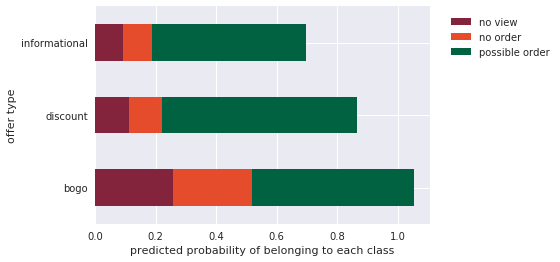


Income: 118385 USD, other, 24 y/o:


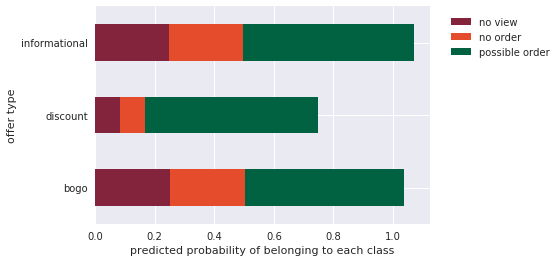


Income: 29441 USD, female, 47 y/o:


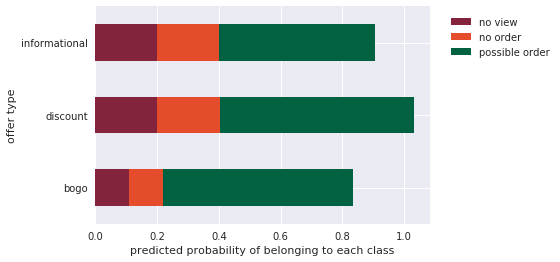


Income: 33835 USD, male, 59 y/o:


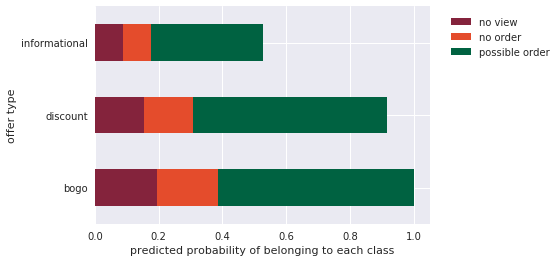


Income: 119267 USD, female, 18 y/o:


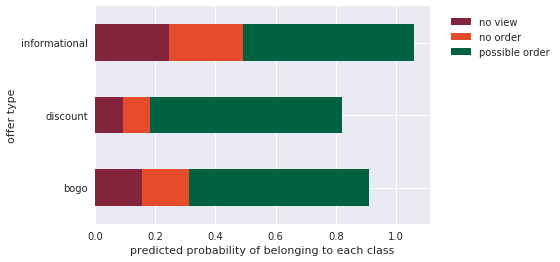


Income: 85146 USD, female, 37 y/o:


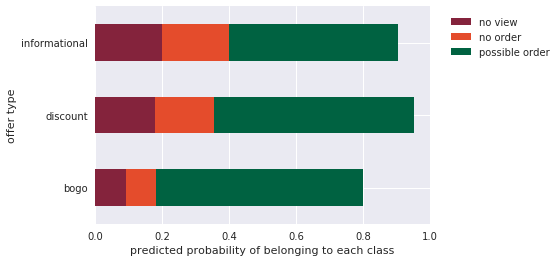


Income: 70816 USD, other, 32 y/o:


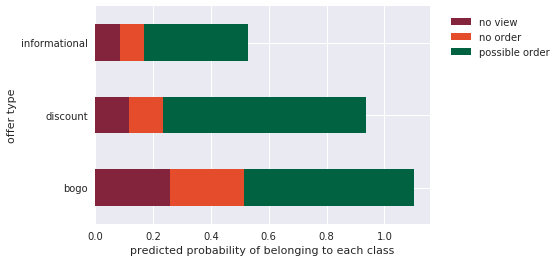


Income: 47565 USD, male, 66 y/o:


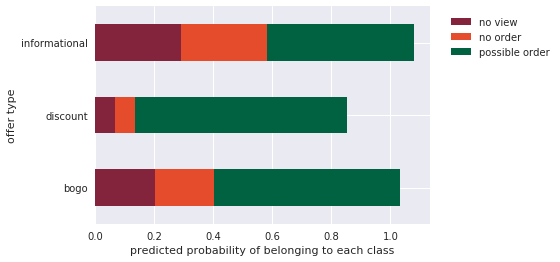


Income: 115821 USD, male, 76 y/o:


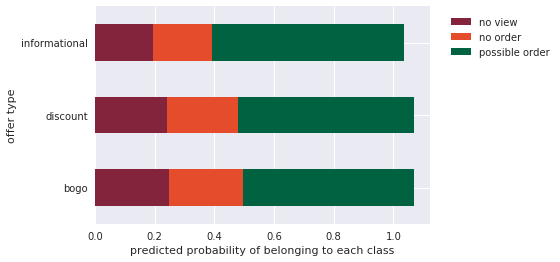


Income: 54680 USD, other, 24 y/o:


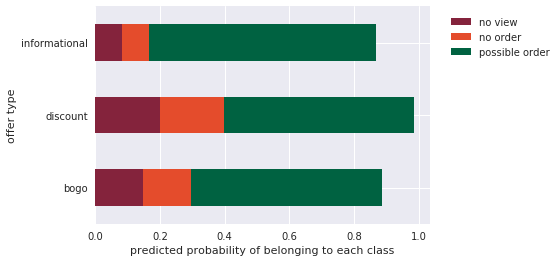

In [51]:
for i in range (10):
    income = df.at[i, "income"]
    gender = df.at[i, "gender"]
    age = df.at[i, "age"]
    print("\nIncome: {} USD, {}, {} y/o:".format(income, gender, age))
    plot_person_preds(df, i)

In [52]:
### FILE SAVING CHECKPOINT ###
filename = 'data/new_customer_preds.csv'
df.to_csv(filename)

___
Please refer to [PROJECT REPORT](https://evanca.github.io/machine-learning_optimizing-app-offers-with-starbucks/) for a conclusions and a high-level overview of the full project.